# Edge Classifier Evaluation Notebook

## Purpose

This notebook compares two edge‐classification approaches against Wolters Kluwer’s labeled dataset:

* **Snippet method** (per-citation snippets; loaded from `snippit_df`)
* **Full opinion method** (full opinion context; loaded from `opinion_df`)

It:

1. Normalizes WK labels and model labels into numeric form.
2. Builds a combined evaluation DataFrame.
3. Plots confusion matrices for both models side by side.
4. Computes accuracy, macro precision, macro recall, and macro F1, with and without the **Unknown** class.

---

## 1. Loading the data

```python
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
```

You load three CSV files:

```python
snippit_df = pd.read_csv(".../WK Labeled vs Snippet Method Model Comparison - Ensemble.csv")
opinion_df = pd.read_csv(".../WK Labeled vs Full Opinion Method Model Comparison.csv")
wk_df      = pd.read_csv(".../Phase One Final Labeled Dataset from WK.csv", encoding='cp1252')
```

* `wk_df` holds the **ground-truth WK labels**.
* `snippit_df` holds the **snippet-based model predictions**.
* `opinion_df` holds the **full-opinion model predictions**.

Only one `snippit_df` line should be active at a time (Ensemble, Claude, Llama, Mistral, etc.).

---

## 2. Formatting the evaluation dataset

```python
def evaluation_data_format(snippit_df, opinion_df, wk_df):
    # Helper function to convert labels to numbers
    def label_to_number(label):
        if label == 'Positive':
            return 1
        elif label == 'Negative':
            return 2
        elif label == 'Unknown':
            return 3
        else:
            return 0

    # Convert each column
    ground_truth   = [label_to_number(l) for l in wk_df['Label']]
    snippit_label  = [label_to_number(l) for l in snippit_df['Label (Model)']]
    opinion_label  = [label_to_number(l) for l in opinion_df['Label (Model)']]

    # Create DataFrame
    df = pd.DataFrame({
        'ground_truth':     ground_truth,
        'snippit_labeled':  snippit_label,
        'opinion_labeled':  opinion_label
    })

    return df
```

### Label encoding

`label_to_number` maps string labels to integers:

* `Positive` → **1**
* `Negative` → **2**
* `Unknown`  → **3**
* Anything else (e.g., missing / unexpected) → **0** (treated as Neutral / Other)

The function returns a unified DataFrame `df` with three aligned columns:

* `ground_truth` – WK labels (numeric)
* `snippit_labeled` – snippet model predictions (numeric)
* `opinion_labeled` – full opinion model predictions (numeric)

Example call:

```python
result = evaluation_data_format(snippit_df, opinion_df, wk_df)
result.head()
```

---

## 3. Confusion matrix visualization

```python
def create_cf_matrix(result):
  '''Input: result dataframe with 3 columns: ground_truth, snippit_labeled, and opinion_labeled
     Output: confusion matrix'''

  # We only plot Neutral, Positive, Negative (0,1,2)
  labels      = [0, 1, 2]
  class_names = ['0-Neutral', '1-Positive', '2-Negative']

  # Compute confusion matrices
  cm_saul    = confusion_matrix(result['ground_truth'], result['snippit_labeled'], labels=labels)
  cm_mistral = confusion_matrix(result['ground_truth'], result['opinion_labeled'], labels=labels)

  # Create side-by-side plots
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))

  # Snippet model confusion matrix
  disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_saul, display_labels=class_names)
  disp1.plot(ax=axes[0], cmap='Blues', colorbar=False)
  axes[0].set_title("Snippit Confusion Matrix")

  # Opinion model confusion matrix
  disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_mistral, display_labels=class_names)
  disp2.plot(ax=axes[1], cmap='Greens', colorbar=False)
  axes[1].set_title("Opinion Confusion Matrix")

  plt.tight_layout()
  plt.show()
```

Key points:

* The confusion matrices **only consider labels 0, 1, 2**:

  * 0 = Neutral / Other
  * 1 = Positive
  * 2 = Negative
* Any rows with label 3 (Unknown) are still in the input, but are **not visualized** because `labels=[0,1,2]`.
* The function plots:

  * Left: snippet model vs ground truth
  * Right: full opinion model vs ground truth

Usage:

```python
create_cf_matrix(result)
```

---

## 4. Aggregate metrics (accuracy, precision, recall, F1)

```python
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
```

### 4.1 Metrics on all labels (including Unknown)

```python
def calc_metrics(df):
  '''
  Input: dataframe with columns: ground_truth, snippit_labeled, opinion_labeled.
  Output: metrics dataframe with accuracy, precision, recall, F1 (macro).
  '''
  y_true = df['ground_truth']
  y_saul = df['snippit_labeled']
  y_mistral = df['opinion_labeled']

  # Accuracy
  acc_saul    = accuracy_score(y_true, y_saul)
  acc_mistral = accuracy_score(y_true, y_mistral)

  # Precision, Recall, F1 (macro = equal weight per class)
  prec_saul, rec_saul, f1_saul, _ = precision_recall_fscore_support(
      y_true, y_saul, average='macro', zero_division=0
  )
  prec_mistral, rec_mistral, f1_mistral, _ = precision_recall_fscore_support(
      y_true, y_mistral, average='macro', zero_division=0
  )

  eval_matrics = pd.DataFrame({
      'Model':     ['Snippit', 'Opinion'],
      'Accuracy':  [acc_saul,  acc_mistral],
      'Precision': [prec_saul, prec_mistral],
      'Recall':    [rec_saul,  rec_mistral],
      'F1':        [f1_saul,   f1_mistral]
  })

  print(eval_matrics)
  return eval_matrics
```

Notes:

* `average='macro'` gives **equal weight** to each class, regardless of frequency.
* `zero_division=0` avoids errors in classes where precision or recall is undefined (e.g., never predicted).

Usage:

```python
eval_metrics = calc_metrics(result)
```

---

### 4.2 Metrics after dropping “Unknown” model predictions

```python
def calc_metrics_without_unknown(df):
  '''
  Input: dataframe with columns: ground_truth, snippit_labeled, opinion_labeled.
  Output: metrics dataframe with accuracy, precision, recall, F1 (macro),
          after dropping rows where the snippet model predicted Unknown (3).
  '''
  # Drop rows where the snippet model predicted Unknown (3)
  df = df[(df['snippit_labeled'] != 3)]

  y_true = df['ground_truth']
  y_saul = df['snippit_labeled']
  y_mistral = df['opinion_labeled']

  # Accuracy
  acc_saul    = accuracy_score(y_true, y_saul)
  acc_mistral = accuracy_score(y_true, y_mistral)

  # Precision, Recall, F1 (macro)
  prec_saul, rec_saul, f1_saul, _ = precision_recall_fscore_support(
      y_true, y_saul, average='macro', zero_division=0
  )
  prec_mistral, rec_mistral, f1_mistral, _ = precision_recall_fscore_support(
      y_true, y_mistral, average='macro', zero_division=0
  )

  eval_matrics = pd.DataFrame({
      'Model':     ['Snippit', 'Opinion'],
      'Accuracy':  [acc_saul,  acc_mistral],
      'Precision': [prec_saul, prec_mistral],
      'Recall':    [rec_saul,  rec_mistral],
      'F1':        [f1_saul,   f1_mistral]
  })

  print(eval_matrics)
  return eval_matrics
```

Notes:

* Rows where **`snippit_labeled == 3` (Unknown)** are **removed** from the evaluation.
* The full opinion model can still have Unknown predictions; those remain in `y_mistral`.
* This helps you understand model quality on the “decisive” predictions only.

Usage:

```python
eval_metrics_all   = calc_metrics(result)
eval_metrics_clean = calc_metrics_without_unknown(result)
```

---

## 5. Typical workflow

1. **Load CSVs** for WK labels, snippet model, and opinion model.

2. **Build the evaluation DataFrame**:

   ```python
   result = evaluation_data_format(snippit_df, opinion_df, wk_df)
   ```

3. **Visualize confusion matrices**:

   ```python
   create_cf_matrix(result)
   ```

4. **Compute metrics on all labels**:

   ```python
   eval_metrics_all = calc_metrics(result)
   ```

5. **Compute metrics after dropping snippet Unknown predictions**:

   ```python
   eval_metrics_clean = calc_metrics_without_unknown(result)
   ```

This gives you both a **visual** and **numeric** comparison of the snippet and full opinion edge classifiers against the WK ground truth.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
#snippit_df = pd.read_csv("/home/sagemaker-user/Edge Classifier Snippet Method/WK Labeled vs Snippet Method Model Comparison.csv")
#snippit_df = pd.read_csv("/home/sagemaker-user/Edge Classifier Snippet Method/WK Labeled vs Snippet Method Model Comparison - Claude.csv")
snippit_df = pd.read_csv("/home/sagemaker-user/Edge Classifier Snippet Method/WK Labeled vs Snippet Method Model Comparison - Ensemble.csv")
#snippit_df = pd.read_csv("/home/sagemaker-user/Edge Classifier Snippet Method/WK Labeled vs Snippet Method Model Comparison - Llama3.csv")
#snippit_df = pd.read_csv("/home/sagemaker-user/Edge Classifier Snippet Method/WK Labeled vs Snippet Method Model Comparison - Mistral.csv")

opinion_df = pd.read_csv("/home/sagemaker-user/Edge Classifier Full Opinion Method/WK Labeled vs Full Opinion Method Model Comparison.csv")
wk_df = pd.read_csv("/home/sagemaker-user/Edge Classifier Snippet Method/Phase One Final Labeled Dataset from WK.csv", encoding='cp1252')

## Formatting Evaluation Dataset

In [5]:
def evaluation_data_format(snippit_df, opinion_df, wk_df):
    # Helper function to convert labels to numbers
    def label_to_number(label):
        if label == 'Positive':
            return 1
        elif label == 'Negative':
            return 2
        elif label == 'Unknown':
            return 3
        # elif label == 'Ambiguous': # adding new condidtion for unknown labels
        #     return 4
        else:
            return 0

    # Convert each column
    ground_truth = [label_to_number(l) for l in wk_df['Label']]
    snippit_label = [label_to_number(l) for l in snippit_df['Label (Model)']]
    opinion_label = [label_to_number(l) for l in opinion_df['Label (Model)']]

    # Create DataFrame
    df = pd.DataFrame({
        'ground_truth': ground_truth,
        'snippit_labeled': snippit_label,
        'opinion_labeled': opinion_label
    })

    return df


## Confusion Matrix

In [10]:
def create_cf_matrix(result):
  '''Input: result dataframe with 3 columns: ground_truth, saul_labeled, and mistral_labeled
     Output: confusion matrix'''
  # labels = [0, 1, 2, 3, 4]
  # class_names = ['0-Neutral', '1-Positive', '2-Negative', '3-Unknown', '4-Ambiguous']
  labels = [0, 1, 2]
  class_names = ['0-Neutral', '1-Positive', '2-Negative']

  # Compute confusion matrices
  cm_saul = confusion_matrix(result['ground_truth'], result['snippit_labeled'], labels=labels)
  cm_mistral = confusion_matrix(result['ground_truth'], result['opinion_labeled'], labels=labels)

  # Create side-by-side plots
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))

  # SaulLM Confusion Matrix
  disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_saul, display_labels=class_names)
  disp1.plot(ax=axes[0], cmap='Blues', colorbar=False)
  axes[0].set_title("Snippit Confusion Matrix")

  # Mistral Confusion Matrix
  disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_mistral, display_labels=class_names)
  disp2.plot(ax=axes[1], cmap='Greens', colorbar=False)
  axes[1].set_title("Opinion Confusion Matrix")

  # Adjust layout
  plt.tight_layout()
  plt.show()

In [12]:
result = evaluation_data_format(snippit_df, opinion_df, wk_df)
result.head()

,ground_truth,snippit_labeled,opinion_labeled
0,0,0,0
1,1,1,0
2,1,1,0
3,0,1,0
4,0,1,0


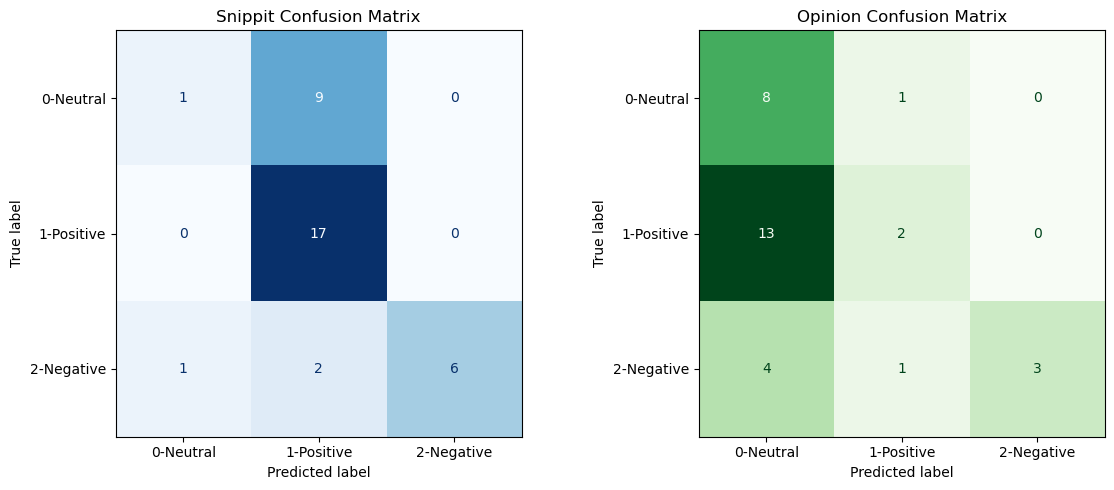

In [13]:
create_cf_matrix(result)

## Accuracy, Precision, Recall, F1

In [11]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calc_metrics(df):
  '''
  Input: a dataframe with 3 columns of labels: ground_truth, saul_labeled, mistral_labeled.
  0 - Neutral, 1 - Positive, 2 - Negative, 3 - Ambiguous
  Output: a result dataframe including: accuracy, precision, recall, F1 score
  '''
  y_true = df['ground_truth']
  y_saul = df['snippit_labeled']
  y_mistral = df['opinion_labeled']

  # Accuracy
  acc_saul = accuracy_score(y_true, y_saul)
  acc_mistral = accuracy_score(y_true, y_mistral)

  # Precision, Recall, F1 (macro = equal weight per class)
  prec_saul, rec_saul, f1_saul, _ = precision_recall_fscore_support(y_true, y_saul, average='macro', zero_division=0)
  prec_mistral, rec_mistral, f1_mistral, _ = precision_recall_fscore_support(y_true, y_mistral, average='macro', zero_division=0)

  eval_matrics = pd.DataFrame({
      'Model': ['Snippit', 'Opinion'],
      'Accuracy': [acc_saul, acc_mistral],
      'Precision': [prec_saul, prec_mistral],
      'Recall': [rec_saul, rec_mistral],
      'F1': [f1_saul, f1_mistral]
  })

  print(eval_matrics)
  return eval_matrics


def calc_metrics_without_unknown(df):
  '''
  Input: a dataframe with 3 columns of labels: ground_truth, saul_labeled, mistral_labeled.
  0 - Neutral, 1 - Positive, 2 - Negative, 3 - Ambiguous
  Output: a result dataframe including: accuracy, precision, recall, F1 score
  '''
  #df = df[(df['snippit_labeled'] != 3) & (df['opinion_labeled'] != 3)]
  df = df[(df['snippit_labeled'] != 3)]
  y_true = df['ground_truth']
  y_saul = df['snippit_labeled']
  y_mistral = df['opinion_labeled']

  # Accuracy
  acc_saul = accuracy_score(y_true, y_saul)
  acc_mistral = accuracy_score(y_true, y_mistral)

  # Precision, Recall, F1 (macro = equal weight per class)
  prec_saul, rec_saul, f1_saul, _ = precision_recall_fscore_support(y_true, y_saul, average='macro', zero_division=0)
  prec_mistral, rec_mistral, f1_mistral, _ = precision_recall_fscore_support(y_true, y_mistral, average='macro', zero_division=0)

  eval_matrics = pd.DataFrame({
      'Model': ['Snippit', 'Opinion'],
      'Accuracy': [acc_saul, acc_mistral],
      'Precision': [prec_saul, prec_mistral],
      'Recall': [rec_saul, rec_mistral],
      'F1': [f1_saul, f1_mistral]
  })

  print(eval_matrics)
  return eval_matrics



In [27]:
eval_matrics = calc_metrics(result)

     Model  Accuracy  Precision    Recall        F1
0  Snippit  0.666667   0.702381  0.588889  0.574074
1  Opinion  0.361111   0.455000  0.312745  0.286905


In [28]:
 eval_matrics = calc_metrics_without_unknown(result)

     Model  Accuracy  Precision    Recall        F1
0  Snippit  0.666667   0.702381  0.588889  0.574074
1  Opinion  0.361111   0.455000  0.312745  0.286905
